In [1]:
# author: Leonardo Filipe
# website: https://www.leonardofilipe.com
# contact: contact[at]leonardofilipe.com
# based on Zhang, L. implementation
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

plt.style.use('seaborn')

def Heston_Calls(series):
    kappa = series['kappa'] # Mean Reversion Speed
    theta = series['theta'] # Long Run Variance
    sigma = series['sigma'] # Volatility of Variance
    rho = series['rho'] # Correlation
    v0 = series['Cv0'] # Initial Variance (I use Call Implied Volatility from BSM instead)
    T = series['T'] # Time to maturity
    s0 = series['s0'] # Spot Price
    K = series['K'] # Strike Price
    N = 10000 # Nº of simulations
    dt = 1/32 # Timestep granularity (related to the nº of steps being generated)
    vega=(4*kappa*theta/(sigma*sigma))
    K1=dt*(kappa*rho/sigma-0.5)/2-rho/sigma
    K2=dt*(kappa*rho/sigma-0.5)/2+rho/sigma
    K3=dt*(1-rho*rho)/2
    ss=K2+K3/2
    yita=4*kappa*np.exp(-kappa*dt)/(sigma*sigma)/(1-np.exp(-kappa*dt))
    sh=ss*np.exp(-kappa*dt)/yita
    S=np.ones(N)*s0
    Ntime=int(T/dt)
    for i in range (0,Ntime):
        v=np.ones(N)*v0
        Zs=np.random.randn(1,N)
        lamb=v*yita
        W=np.random.noncentral_chisquare(vega,lamb)
        v2=W*np.exp(-kappa*dt)/yita
        K0=-lamb*sh/(1-2*sh)+0.5*vega*np.log(1-2*sh)-(K1+K3/2)*v
        S=S*np.exp(K0+K1*v+K2*v2+np.multiply(np.sqrt(K3*(v+v2)),Zs))
    payoff=np.maximum(S-K,0)
    return np.mean(payoff)

def Heston_Puts(series):
    kappa = series['kappa'] # Mean Reversion Speed
    theta = series['theta'] # Long Run Variance
    sigma = series['sigma'] # Volatility of Variance
    rho = series['rho'] # Correlation
    v0 = series['Pv0'] # Initial Variance (I use Put Implied Volatility from BSM instead)
    T = series['T'] # Time to maturity
    s0 = series['s0'] # Spot Price
    K = series['K'] # Strike Price
    N = 10000 # Nº of simulations
    dt = 1/32 # Timestep granularity (related to the nº of steps being generated)
    vega=(4*kappa*theta/(sigma*sigma))
    K1=dt*(kappa*rho/sigma-0.5)/2-rho/sigma
    K2=dt*(kappa*rho/sigma-0.5)/2+rho/sigma
    K3=dt*(1-rho*rho)/2
    ss=K2+K3/2
    yita=4*kappa*np.exp(-kappa*dt)/(sigma*sigma)/(1-np.exp(-kappa*dt))
    sh=ss*np.exp(-kappa*dt)/yita
    S=np.ones(N)*s0
    Ntime=int(T/dt)
    for i in range (0,Ntime):
        v=np.ones(N)*v0
        Zs=np.random.randn(1,N)
        lamb=v*yita
        W=np.random.noncentral_chisquare(vega,lamb)
        v2=W*np.exp(-kappa*dt)/yita
        K0=-lamb*sh/(1-2*sh)+0.5*vega*np.log(1-2*sh)-(K1+K3/2)*v
        S=S*np.exp(K0+K1*v+K2*v2+np.multiply(np.sqrt(K3*(v+v2)),Zs))
    payoff=np.maximum(K-S,0)
    return np.mean(payoff)

db = pd.read_hdf("optiondata.h5")
db['Now'] = pd.to_datetime(db['Now'])
db['Maturity'] = pd.to_datetime(db['Maturity'])

In [2]:
HTest = pd.DataFrame({'T': db['Expiration'],'Cv0': db['CallImpVol']**2, 'Now': db['Now'],
                     's0': db['Spot'],'Pv0': db['PutImpVol']**2,'Put': db['PutMid'],
                     'K': db['Strike'],'Call': db['CallMid'],'Maturity': db['Maturity']})

HTest[HTest['Cv0'] < 0.001] = 0
HTest[HTest['Pv0'] < 0.001] = 0
HTest = HTest.loc[(HTest!=0).any(1)]
HTest = HTest.reset_index().drop('index',axis=1)

HTest['Moneyness'] = abs(HTest['K']/HTest['s0'])
HTest['theta'] = 0.49254
HTest['kappa'] = 0.05749
HTest['sigma'] = 0.29549
HTest['rho'] = 0.08996

In [3]:
HTest['Heston Call'] = round(HTest.apply(Heston_Calls, axis=1),2)
HTest['CError'] = HTest['Heston Call']/HTest['Call']-1
abs(HTest['CError']).describe()

count    429.000000
mean       0.055473
std        0.086753
min        0.000046
25%        0.008908
50%        0.023512
75%        0.053536
max        0.531429
Name: CError, dtype: float64

In [4]:
HTest['Heston Put'] = round(HTest.apply(Heston_Puts, axis=1),2)
HTest['PError'] = HTest['Heston Put']/HTest['Put']-1
abs(HTest['PError']).describe()

count    429.000000
mean       0.023046
std        0.031725
min        0.000041
25%        0.005678
50%        0.013049
75%        0.025475
max        0.183876
Name: PError, dtype: float64

In [5]:
HTest.groupby('Maturity')['CError'].describe()

,count,mean,std,min,25%,50%,75%,max
Maturity,,,,,,,,
2018-05-18 17:30:00,39.0,-0.220747,0.146683,-0.531429,-0.284052,-0.199533,-0.104313,-0.010370
2018-06-15 17:30:00,62.0,0.115566,0.091857,-0.084211,0.056513,0.081342,0.155260,0.431579
2018-09-21 17:30:00,105.0,0.006009,0.045082,-0.322857,-0.004225,0.003305,0.020472,0.113433
2018-12-21 17:30:00,125.0,0.021562,0.033902,-0.040094,0.004083,0.012863,0.032671,0.201762
2019-03-15 17:30:00,98.0,0.019552,0.016766,-0.018062,0.007558,0.018055,0.031539,0.061865


In [6]:
HTest.groupby('Maturity')['PError'].describe()

,count,mean,std,min,25%,50%,75%,max
Maturity,,,,,,,,
2018-05-18 17:30:00,39.0,-0.106613,0.043953,-0.183876,-0.140145,-0.100135,-0.072675,-0.034112
2018-06-15 17:30:00,62.0,-0.010102,0.014147,-0.042185,-0.020333,-0.008477,-0.000247,0.014140
2018-09-21 17:30:00,105.0,-0.018980,0.015792,-0.062735,-0.028782,-0.016298,-0.007307,0.014952
2018-12-21 17:30:00,125.0,-0.010332,0.014471,-0.055134,-0.018550,-0.010194,0.000802,0.019545
2019-03-15 17:30:00,98.0,0.004433,0.013770,-0.030744,-0.004559,0.004555,0.012311,0.050438


<IPython.core.display.Javascript object>


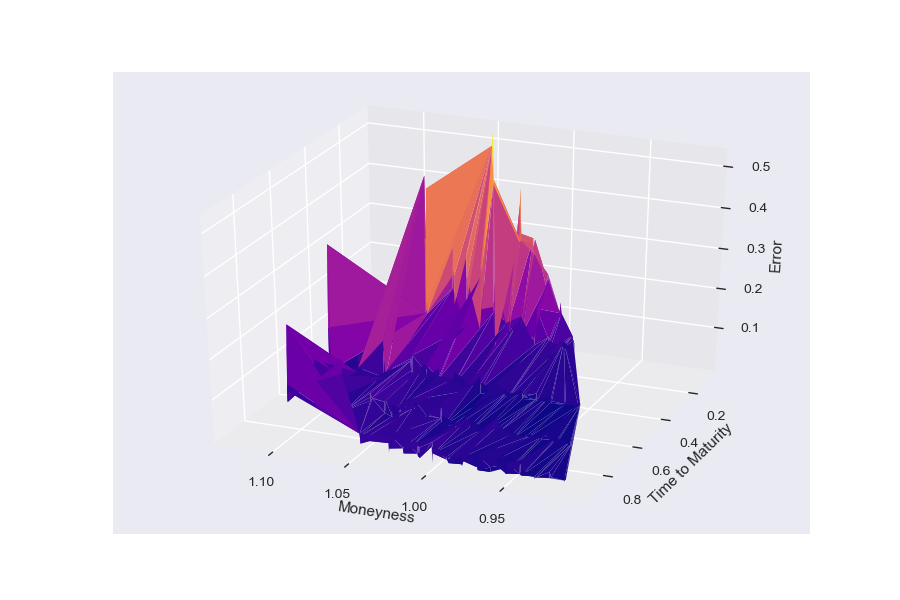

In [7]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(HTest['Moneyness'], HTest['T'], abs(HTest['CError']), cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Error')

ax.dist=12
ax.view_init(30, 112.5)
plt.show()

<IPython.core.display.Javascript object>


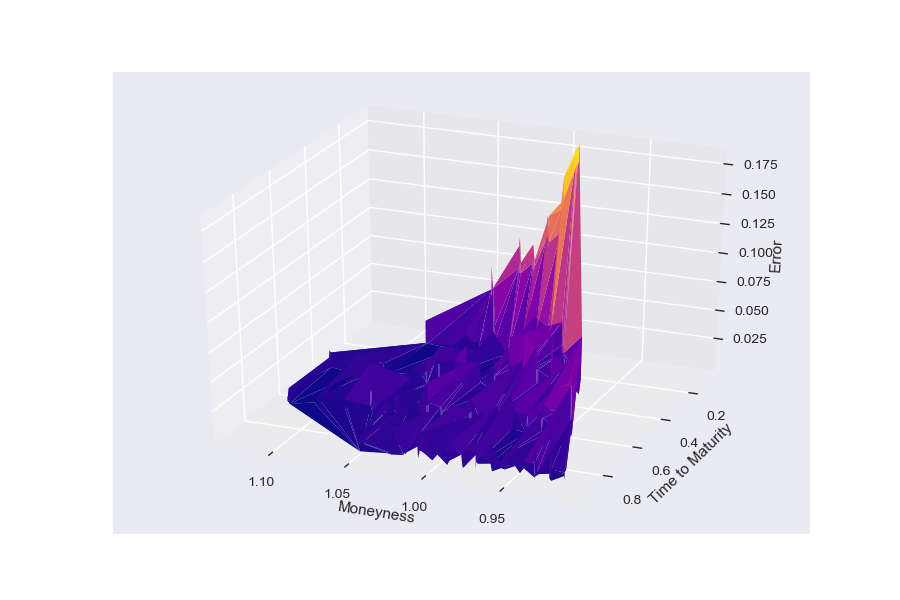

In [8]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(HTest['Moneyness'], HTest['T'], abs(HTest['PError']), cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Error')

ax.dist=12
ax.view_init(30, 112.5)
plt.show()